### Imports


In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


### Load Data

In [64]:
data = pd.read_csv("data/mushrooms.csv")


### Data Exploration

In [65]:
data.head(10)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


Display the distribution of edible and poisonous mushrooms.

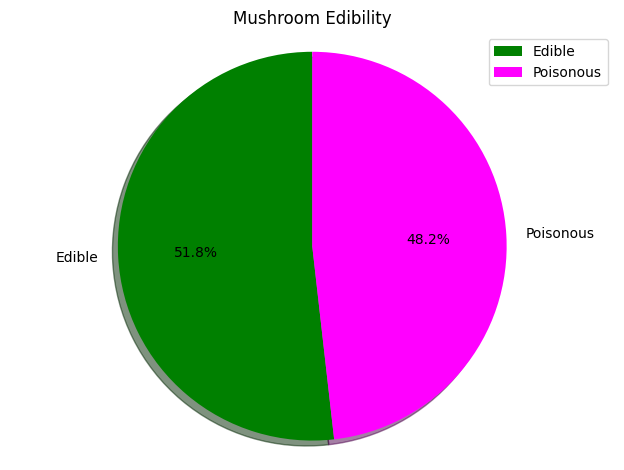

In [66]:
labels = "Edible", "Poisonous"
sizes = [
    data.describe()["class"]["freq"],
    data.describe()["class"]["count"] - data.describe()["class"]["freq"],
]

fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
    colors=["green", "magenta"],
)

ax.set_title("Mushroom Edibility")
ax.legend(labels, loc="upper right")
ax.axis("equal")
plt.tight_layout()

plt.show()


Mushroom edibility by cap shape

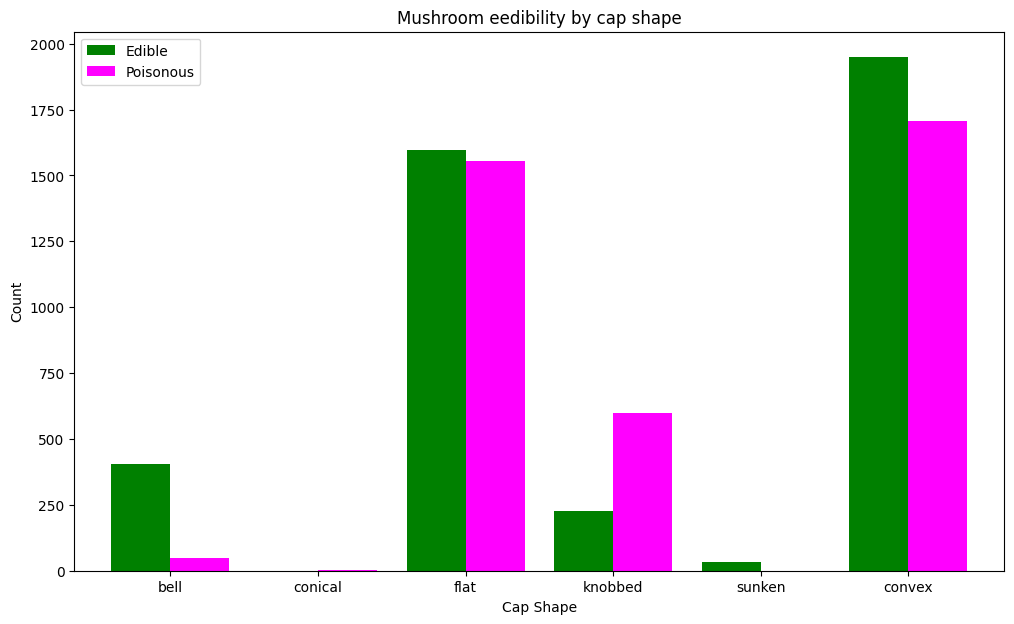

In [67]:
cap_shapes = data.groupby(["cap-shape", "class"]).size().unstack()
cap_shapes.fillna(0)
cap_shapes_mapping = {
    "b": "bell",
    "c": "conical",
    "x": "convex",
    "f": "flat",
    "k": "knobbed",
    "s": "sunken",
}

cap_shapes.rename(index=cap_shapes_mapping, inplace=True)

ax = cap_shapes.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom eedibility by cap shape")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Shape")
labels = ["Edible", "Poisonous"]

ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by cap surface

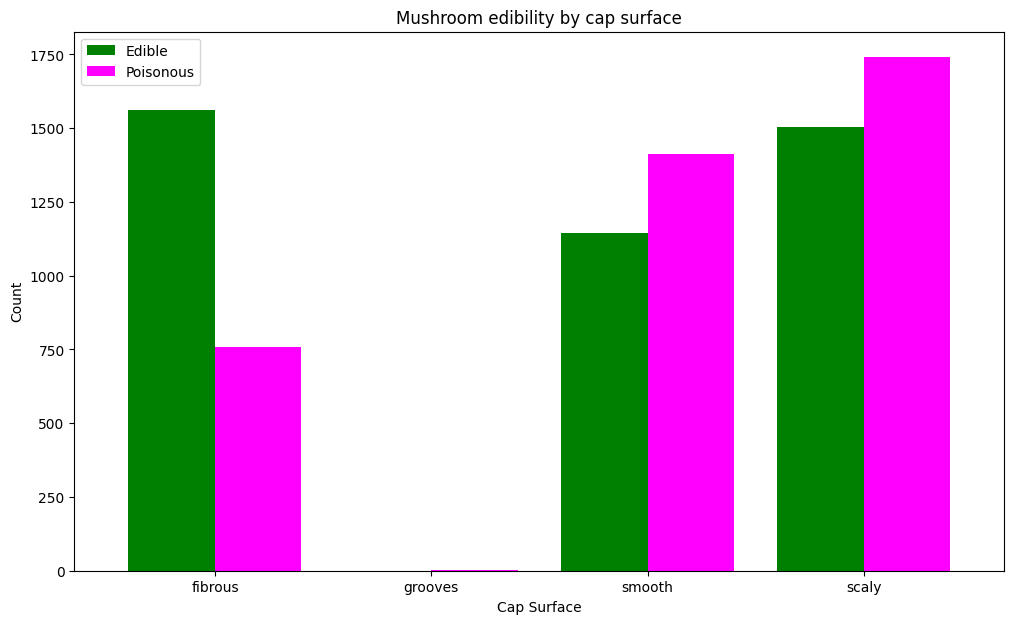

In [68]:
cap_surfaces = data.groupby(["cap-surface", "class"]).size().unstack()
cap_surfaces.fillna(0)

cap_surfaces_mapping = {
    "f": "fibrous",
    "g": "grooves",
    "s": "smooth",
    "y": "scaly",
}

cap_surfaces.rename(index=cap_surfaces_mapping, inplace=True)

ax = cap_surfaces.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by cap surface")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Surface")
labels = ["Edible", "Poisonous"]

ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by color

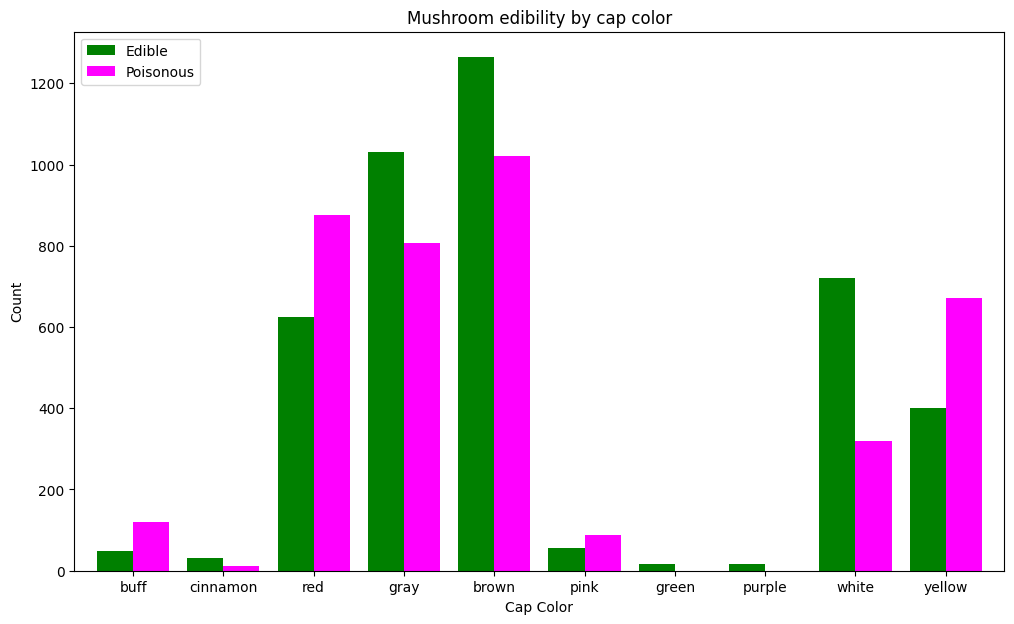

In [69]:
cap_colors = data.groupby(["cap-color", "class"]).size().unstack()
cap_colors.fillna(0)

cap_colors_mapping = {
    "n": "brown",
    "b": "buff",
    "c": "cinnamon",
    "g": "gray",
    "r": "green",
    "p": "pink",
    "u": "purple",
    "e": "red",
    "w": "white",
    "y": "yellow",
}

cap_colors.rename(index=cap_colors_mapping, inplace=True)

ax = cap_colors.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by cap color")
ax.set_xlabel("Cap Color")
ax.set_ylabel("Count")

labels = ["Edible", "Poisonous"]
ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by bruises

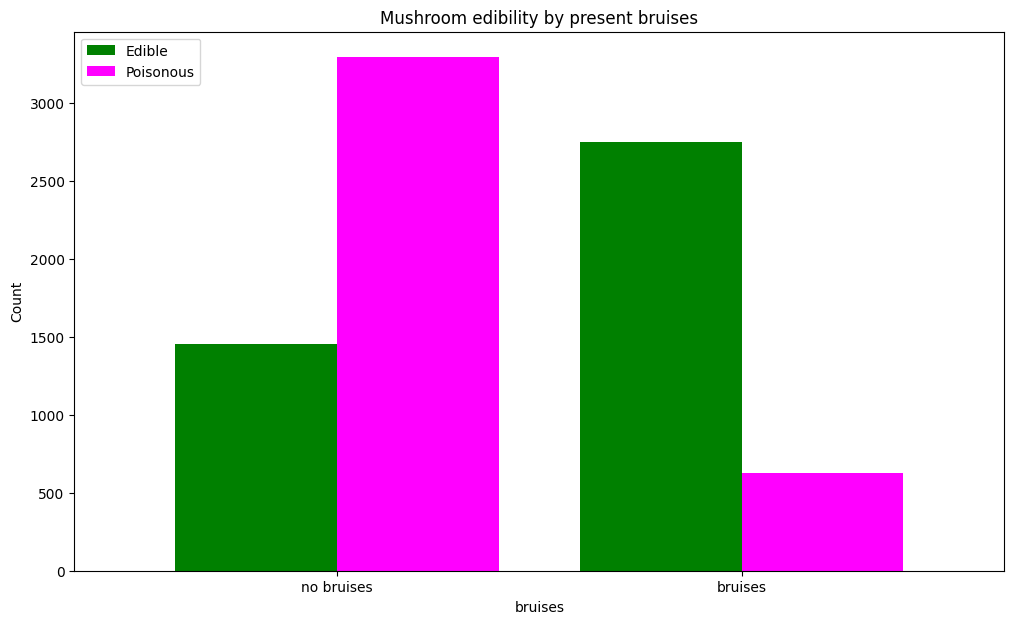

In [70]:
bruises = data.groupby(["bruises", "class"]).size().unstack()

bruise_mapping = {"f": "no bruises", "t": "bruises"}

bruises.rename(index=bruise_mapping, inplace=True)

ax = bruises.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by present bruises")
ax.set_ylabel("Count")

labels = ["Edible", "Poisonous"]
plt.legend(labels, loc="upper left")
plt.show()


### Declare utility functions to imitiate missing data

In [71]:
def create_missing_data(data, missing_ratio):
    """
    Create random missing data in a pandas DataFrame.

    Parameters:
        data (pandas.DataFrame): The input DataFrame.
        missing_ratio (float): The ratio of missing values to create (between 0 and 1).

    Returns:
        pandas.DataFrame: The DataFrame with random missing values.
    """

    data_with_missing = data.copy()
    num_missing_values = int(data.size * missing_ratio)
    missing_indices = np.random.choice(data.size, size=num_missing_values, replace=False)
    data_with_missing.values.flat[missing_indices] = np.nan

    return data_with_missing


In [72]:
def fill_with_most_common(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col


### Train Models

Split the data into train and test 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("class", axis=1),
    data["class"],
    test_size=0.2,
    shuffle=True,
    random_state=42,
    stratify=data["class"],
)


## Create missing data

In [74]:
X_train = create_missing_data(X_train, 0.7)
X_train = X_train.apply(lambda col: fill_with_most_common(col))

X_test = create_missing_data(X_test, 0.7)
X_test = X_test.apply(lambda col: fill_with_most_common(col))


Replace edible with 1 and poisonous with 0

In [75]:
y_train = y_train.map({"e": 0, "p": 1})
y_test = y_test.map({"e": 0, "p": 1})


### Preprocessing

Create preprocessor

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            data.drop("class", axis=1).select_dtypes(exclude="object").columns,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            data.drop("class", axis=1).select_dtypes(include="object").columns,
        ),
    ]
)


## Create Models

### Create a SVM model

In [77]:
from sklearn import svm

svm_model = svm.SVC(kernel="linear")  # Linear Kernel

svm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", svm_model)])


Search for the best parameters using grid search

In [78]:
svm_param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": [1, 0.1, 0.01],
    "classifier__kernel": ["rbf", "poly", "sigmoid"],
}

svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)


In [79]:
svm_grid_search.fit(X_train, y_train)

print(f"Best parameters: {svm_grid_search.best_params_}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


Predict SVM model scores

In [80]:
svm_predictions = svm_grid_search.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_predictions)}")


Accuracy: 0.9027692307692308


### Create XGBoost model

In [81]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier()

xgb_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb_model)])


Search for the parameters with Grid Search

In [82]:
xgb_param_grid = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__learning_rate": [0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1, verbose=1)


In [83]:
grid_search.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grid_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best parameters set found on development set:
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}


Predict scores

In [84]:
xgb_predictions = grid_search.predict(X_test)

print("Accuracy score: ", accuracy_score(y_test, xgb_predictions))


Accuracy score:  0.8990769230769231


### RandomForest classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", random_forest)]
)


Find the best parameters using Grid Search for the RandomForest classifier

In [86]:
rf_param_grid = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth": [None, 5, 10, 20],
}

rf_grid_search = GridSearchCV(random_forest_pipeline, rf_param_grid, cv=5, n_jobs=-1, verbose=1)


In [87]:
rf_grid_search.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(rf_grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters set found on development set:
{'classifier__max_depth': None, 'classifier__n_estimators': 150}


Make the predictions

In [88]:
rf_predictions = rf_grid_search.predict(X_test)

print("Accuracy score: ", accuracy_score(y_test, rf_predictions))


Accuracy score:  0.8972307692307693


### Create Neural Network model

In [89]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    CategoryEncoding,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    Input,
)

from sklearn.preprocessing import OneHotEncoder


Split test data into validation and test

In [90]:
X_validation, X_test, y_validation, y_test = train_test_split(
    X_test, y_test, test_size=0.5, shuffle=True, random_state=42, stratify=y_test
)


Encode input data with OneHotEncoder

In [91]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_onehot = onehot_encoder.fit_transform(X_train)
X_test_onehot = onehot_encoder.transform(X_test)
X_validation_onehot = onehot_encoder.transform(X_validation)

print(X_train_onehot.shape[1])
print(X_test_onehot.shape[1])
print(X_validation_onehot.shape[1])


116
116
116


Create the layers for the neural network

In [102]:
neural_network = Sequential()

neural_network.add(Dense(units=16, activation="elu", input_shape=(X_train_onehot.shape[1],)))
neural_network.add(Dropout(0.5))
neural_network.add(Dense(units=16, activation="elu"))
neural_network.add(Dropout(0.5))
neural_network.add(Dense(units=1, activation="sigmoid"))

neural_network.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [103]:
nn_history = neural_network.fit(
    X_train_onehot,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation_onehot, y_validation),
)


Epoch 1/100


Evaluate neural network

In [ ]:
neural_network.evaluate(X_test_onehot, y_test)


26/26 [==============================] - 0s 4ms/step - loss: 0.2306 - accuracy: 0.9016


[0.23061680793762207, 0.9015989899635315]

Graph the loss and accuracy

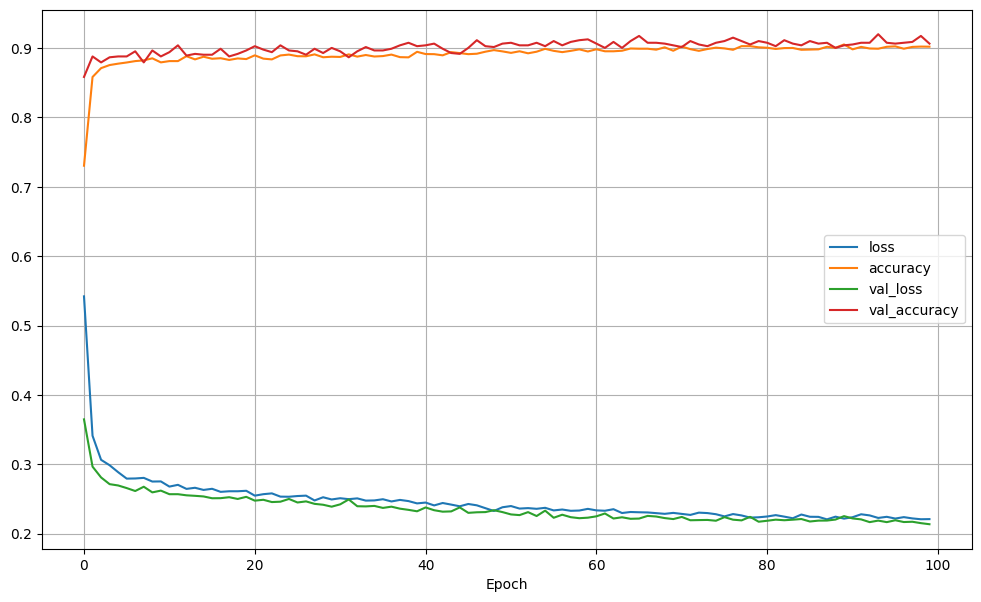

In [ ]:
pd.DataFrame(nn_history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.xlabel("Epoch")
plt.show()


## Convolutional Neural Network

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    Flatten,
    BatchNormalization,
    Activation,
)

from sklearn.preprocessing import OneHotEncoder


Encode the data with OneHotEncoder

In [ ]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_onehot = onehot_encoder.fit_transform(X_train)
X_test_onehot = onehot_encoder.transform(X_test)
X_validation_onehot = onehot_encoder.transform(X_validation)

print(X_train_onehot.shape[1])
print(X_test_onehot.shape[1])
print(X_validation_onehot.shape[1])


116
116
116


## Create the layers for CNN

Conv1D Layer (filters=16, kernel_size=3, strides=1, padding="same"):

    This is a 1D convolutional layer that performs convolution on the input data.
    It uses 16 filters, each of size 3, to extract 16 different features from the input.
    The stride of 1 means the filters move one step at a time.
    Padding="same" ensures that the output has the same spatial dimensions as the input.

BatchNormalization:

    This layer normalizes the activations of the previous layer.
    It helps in stabilizing and accelerating the training process by reducing the internal covariate shift.

Activation("relu"):

    ReLU (Rectified Linear Unit) is an activation function that introduces non-linearity.
    It applies the element-wise rectified linear activation to the output of the previous layer.

MaxPooling1D Layer (pool_size=2, strides=2):

    This layer performs max pooling, which downsamples the input by taking the maximum value in each region.
    It uses a pool size of 2, meaning it takes the maximum value within a window of size 2.
    The stride of 2 means the pooling window moves two steps at a time.

Conv1D Layer (filters=32, kernel_size=3, strides=1, padding="same"):

    This is another 1D convolutional layer with 32 filters and a kernel size of 3.
    It extracts 32 different features from the input using convolution.

BatchNormalization:

    Again, this layer normalizes the activations of the previous layer.

Activation("relu"):

    Applies ReLU activation to the output of the previous layer.

MaxPooling1D Layer (pool_size=2, strides=2):

    Performs max pooling with a pool size of 2 and stride of 2.

Flatten:

    This layer flattens the previous layer's output into a 1D vector.
    It converts the multi-dimensional feature maps into a single continuous vector.

Dense Layer (units=16, activation="elu"):

    Adds a fully connected layer with 16 units (neurons).
    It connects every neuron in this layer to every neuron in the previous layer.
    The activation function used here is ELU (Exponential Linear Unit).

Dense Layer (units=16, activation="elu"):

    Adds another fully connected layer with 16 units and ELU activation.

Dense Layer (units=1, activation="sigmoid"):

    Adds a final fully connected layer with 1 unit and sigmoid activation.
    Sigmoid activation is commonly used for binary classification problems to produce a probability output.

In [ ]:
cnn = Sequential()

# create convolutional neural network

cnn.add(
    Conv1D(
        filters=16,
        kernel_size=3,
        strides=1,
        padding="same",
        input_shape=(X_train_onehot.shape[1], 1),
    )
)
cnn.add(BatchNormalization())
cnn.add(Activation("elu"))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling1D(pool_size=2, strides=2))

cnn.add(
    Conv1D(
        filters=32,
        kernel_size=3,
        strides=1,
        padding="same",
    )
)

cnn.add(BatchNormalization())
cnn.add(Activation("elu"))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling1D(pool_size=2, strides=2))
cnn.add(Flatten())

cnn.add(Dense(units=16, activation="elu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=16, activation="elu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=16, activation="elu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=1, activation="sigmoid"))

cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In the provided code, the input shape of the CNN is defined as (X_train_onehot.shape[1], 1), which means the network expects input data with shape (num_features, 1). However, the one-hot encoded data (X_train_onehot and X_validation_onehot) have a shape of (num_samples, num_features).

To match the expected input shape, the reshape operation is applied to the input data.

This reshapes the input data to have dimensions (num_samples, num_features, 1). The additional dimension of size 1 represents the channel dimension, which is required for convolutional layers.

In [ ]:
cnn_history = cnn.fit(
    X_train_onehot.reshape(X_train_onehot.shape[0], X_train_onehot.shape[1], 1),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(
        X_validation_onehot.reshape(X_validation_onehot.shape[0], X_validation_onehot.shape[1], 1),
        y_validation,
    ),
)


Epoch 1/100


204/204 [==============================] - 6s 15ms/step - loss: 0.4483 - accuracy: 0.7837 - val_loss: 0.7079 - val_accuracy: 0.5628
Epoch 2/100
204/204 [==============================] - 2s 11ms/step - loss: 0.3267 - accuracy: 0.8569 - val_loss: 0.3423 - val_accuracy: 0.8534
Epoch 3/100
204/204 [==============================] - 2s 11ms/step - loss: 0.3119 - accuracy: 0.8600 - val_loss: 0.3519 - val_accuracy: 0.8411
Epoch 4/100
204/204 [==============================] - 2s 12ms/step - loss: 0.2922 - accuracy: 0.8743 - val_loss: 0.2721 - val_accuracy: 0.8781
Epoch 5/100
204/204 [==============================] - 2s 12ms/step - loss: 0.2823 - accuracy: 0.8709 - val_loss: 0.2601 - val_accuracy: 0.9002
Epoch 6/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2727 - accuracy: 0.8789 - val_loss: 0.2567 - val_accuracy: 0.8966
Epoch 7/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2615 - accuracy: 0.8823 - val_loss: 0.2761 - val_accuracy: 0.8818
Epoc

Evaluate CNN

In [ ]:
cnn.evaluate(X_test_onehot.reshape(X_test_onehot.shape[0], X_test_onehot.shape[1], 1), y_test)


10/26 [==========>...................] - ETA: 0s - loss: 0.5128 - accuracy: 0.8687

26/26 [==============================] - 0s 6ms/step - loss: 0.4016 - accuracy: 0.8881


[0.4015711545944214, 0.8880688548088074]

Plot the loss and accuracy for CNN

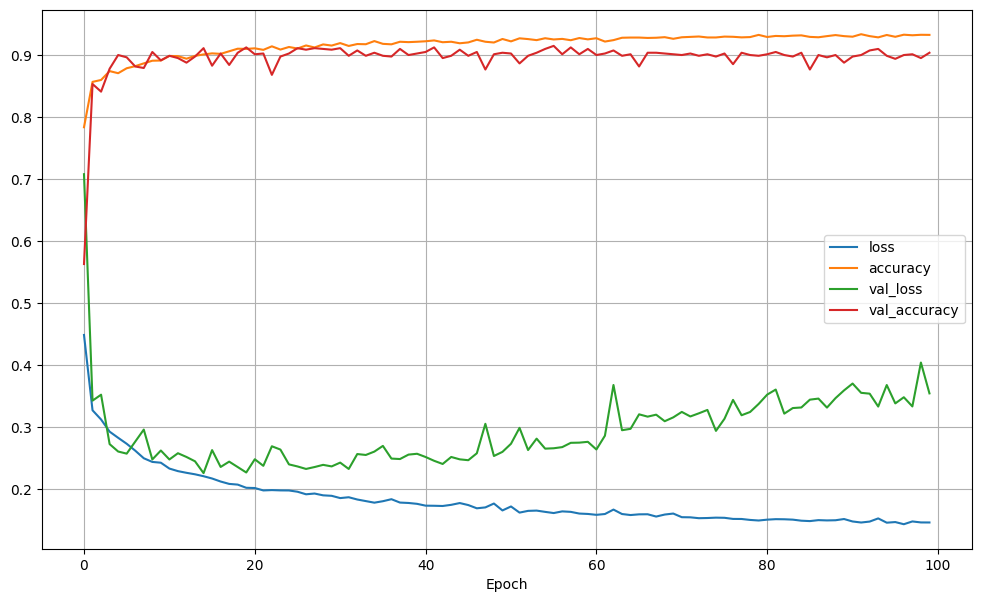

In [ ]:
pd.DataFrame(cnn_history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.xlabel("Epoch")
plt.show()
